# Lab03: Logistic Regression.

- Student ID: 20127567
- Student name: Lê Nguyễn Bình Nam

**How to do your homework**


You will work directly on this notebook; the word `TODO` indicate the parts you need to do.

You can discuss ideas with classmates as well as finding information from the internet, book, etc...; but *this homework must be your*.

**How to submit your homework**

Before submitting, rerun the notebook (`Kernel` ->` Restart & Run All`).

Then create a folder named `ID` (for example, if your ID is 1234567, then name the folder `1234567`). Copy file notebook to this folder, compress and submit it on moodle.

**Contents:**
- Logistic Regression.

## 1. Feature Extraction

### Import Library

In [43]:
using Flux, Images, MLDatasets, Plots
using Statistics, Distributions
using MLJ 
gr()

Plots.GRBackend()

### Load data

In [44]:
train_x, train_y = MNIST.traindata(Int64);
test_x, test_y = MNIST.testdata(Int64);

train_x_flatten = Flux.flatten(train_x)'
test_x_flatten = Flux.flatten(test_x)'

size(train_x_flatten), size(train_y), size(test_x_flatten), size(test_y)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Admin\.julia\packages\MLDatasets\A3giY\src\datasets\vision\mnist.jl:187
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Admin\.julia\packages\MLDatasets\A3giY\src\datasets\vision\mnist.jl:195


((60000, 784), (60000,), (10000, 784), (10000,))

### Extract Features

So we basically have 70000 samples with each sample having 784 features - pixels in this case and a label - the digit the image represent.

Let’s play around and see if we can extract any features from the pixels that can be more informative. First I’d like to know more about average intensity - that is the average value of a pixel in an image for the different digits

In [45]:
function compute_average_intensity(x, y)
    mean = zeros(10) # 10 is number of labels
    #TODO compute average intensity for each label
    count = zeros(10)
    index = 0
    for i in 1:60000
        mean[y[i]+1] += sum(x[i,:])
        count[y[i]+1] += 1
        index +=1       
    end
    for i in 1:10
        mean[i] = mean[i]/count[i]
    end
    return mean
end

l_mean = compute_average_intensity(train_x_flatten, train_y);
print(l_mean)

[34665.99307783218, 15193.648620587363, 29783.10775427996, 28294.706246941772, 24263.40893529613, 25739.57885998893, 27449.37090233187, 22896.377334397446, 30019.183900188003, 24508.181375021013]

Plot the average intensity using matplotlib

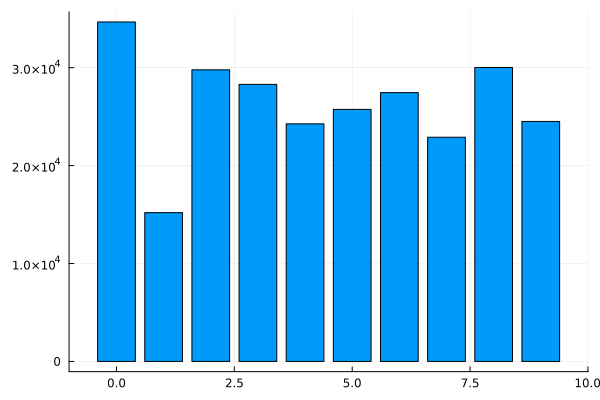

In [46]:
bar(0:9, l_mean, legend=false)

As we can see there are some differences in intensity. The digit “1” is the less intense while the digit “0” is the most intense. So this new feature seems to have some predictive value if you wanted to know if say your digit is a “1” or not.

In [47]:
#TODO compute average intensity for each data sample
intensity = sum(train_x_flatten,dims=2) ./ 784
size(intensity)

(60000, 1)

Some digits are symmetric (1, 3, 8, 0) some are not (2, 4, 5, 6, 9). Creating a new feature capturing this could be useful. Specifically, we calculate $s = -\frac{s_1 + s_2}{2}$ for each image:
- $s_1$: flip the image along y-axis and compute the mean value of result
- $s_2$: flip the image along x-axis and compute the mean value of result

In [48]:
function compute_symmetry(train_x)
    symmetry = []
    for i in 1:size(train_x)[1]
        img = reshape(train_x[i,:], (28,28))
        s1 = mean(abs.(img - reverse(img, dims=1)))
        s2 = mean(abs.(img - reverse(img, dims=2)))
        s = -0.5 .* (s1 + s2)
        append!(symmetry, s)
    end
    return symmetry
end

symmetry = compute_symmetry(train_x_flatten)
size(symmetry)

(60000,)

Visualize 10 samples in order to illustrate symmetry

,,,,,,,,,

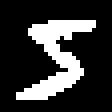
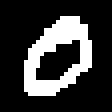
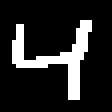
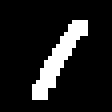
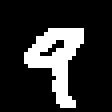
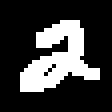
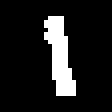
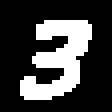
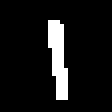
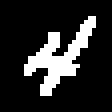

In [49]:
num_img = 10
img_flat = train_x_flatten[1:num_img,:]
img = [reshape(img_flat[i,:], (28,28))' for i in 1:num_img]
[colorview(Gray, Float32.(img[i])) for i in 1:num_img]

,,,,,,,,,

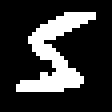
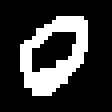
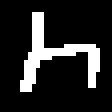
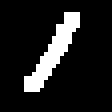
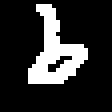
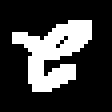
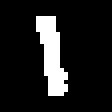
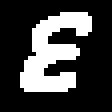
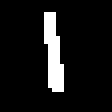
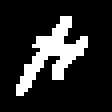

In [50]:
img_reverse_flat = reverse(img_flat, dims=2)
img_reverse = [reshape(img_reverse_flat[i,:], (28,28))' for i in 1:num_img]
[colorview(Gray, Float32.(img_reverse[i])) for i in 1:num_img]

Our new training data will have 60000 samples and 2 features: intensity, symmetry.

In [51]:
#TODO create X_new by horizontal stack intensity and symmetry
train_x_new =  hcat(intensity, symmetry)
size(train_x_new)

(60000, 2)

## 2. Training 

Usually logistic regression is a good first choice for classification. In this homework we use logistic regression for classifying digit 1 images and not digit 1's images.

### Normalize data

In data process, you will first process training data. The parameter obtained in the process will be reused for processing test set

First normalize data using Z-score normalization

- **TODO: Study about Z-score normalization**

    - The normal distribution is an extremely important probability distribution in many fields. It is a family of distributions of the same general form, differing only in mean and standard deviation (severity of dispersion).
- The average value: 
$$\mu=\frac{1}{n}\sum_{i=1}^{n}x_i$$
- Standard deviation:
$$\sigma=\sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i-\mu)^2}$$
- Given any data point, we can estimate its distance from the mean by standard deviation. Specifically:
$$z=\frac{x-\mu}{\sigma}$$
- So, the Z-score is a measure that measures the distance of a value from the mean by standard deviation, and it follows a normal distribution.
- **TODO: Why should we normalize data?**
    - Bring data attributes to a single form, easy to process, update, train, compare, etc.
    - For large data tables, data is reduced, thereby increasing processing speed, saving memory, etc.
    - Remove redundant data, abnormal data, etc.

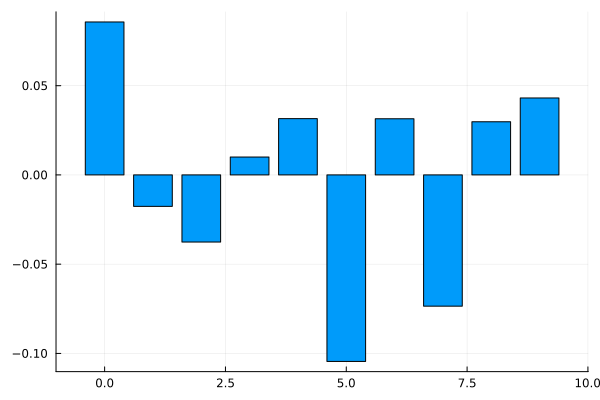

In [52]:
function normalize(x_train, mean_=nothing, std_=nothing)
    if mean_ == nothing && std_ == nothing
        #TODO normalize x_train
        #return `normalized_train_x`, `mean_`, `std_`
        #mean_ and std_ will be re-used to pre-process test set
        mean_ = mean(x_train)
        std_ = std(x_train)
        normalized_train_x = (x_train .- mean_)./std_
        return normalized_train_x, mean_, std_
    end
    normalized_train_x = (x_train .- mean_)./std_
    return normalized_train_x
    #return `normalized_train_x` calculated by using mean_ and std_ (both of them are passed and not null)
end

normalized_train_x, mean_, std_ = normalize(train_x_new)

s_mean = compute_average_intensity(normalized_train_x, train_y)
bar(0:9, s_mean, legend=false)

### Construct  data

In [53]:
# change the label: y=1 -> stay unchanged, y!=1 -> y=0
train_y_new = reshape(deepcopy(train_y), (size(train_y)[1], 1))
train_y_new[train_y_new .!= 1] .= 0
size(train_y_new)

(60000, 1)

In [54]:
# contruct data by adding ones
add_one_train_x = hcat(ones(size(normalized_train_x)[1],), normalized_train_x)
size(add_one_train_x)

(60000, 3)

### Sigmoid function and derivative of the sigmoid function

In [55]:
function sigmoid_activation(x)
    """
    Compute the sigmoid activation value for a given input
    """
    return 1.0 ./ (1.0 .+ exp.(-x))
end

function sigmoid_deriv(x)
    """
    Compute the derivative of the sigmoid function ASSUMING
    that the input 'x' has already been passed through the sigmoid
    activation function
    """
    return x .* (1 .- x)
end

sigmoid_deriv (generic function with 1 method)

### Compute output

In [56]:
function compute_h(W, X)
    """
    Compute output: Take the inner product between our features 'X' and the weight
    matrix 'W'
    """
    return X*W
end

function predict(W, X)
    """
    Take the inner product between our features and weight matrix, 
    then pass this value through our sigmoid activation
    """
    preds = sigmoid_activation(compute_h(W, X))

    # apply a step function to threshold the outputs to binary
    # class labels
    preds[preds .<= 0.5] .= 0
    preds[preds .> 0] .= 1

    return preds
end

predict (generic function with 1 method)

### Compute gradient

**Loss Function: Average negative log likelihood**
$$\mathcal{L}=\dfrac{1}{N} \sum_{i=1}^{N} -\left(y^{i}\ln h_{\mathbf{w}}\left(\mathbf{x}^{i}\right)+\left(1-y^{i}\right)\ln \left(1-h_{\mathbf{w}}\left(x^{i}\right)\right)\right) $$


$$\text{Sigmoid Activation: } z= \sigma \left(h\right)= \dfrac{1}{1+e^{-h}}$$

$$\text{Cross-entropy: } J(w)=-\left({ylog(z)+(1-y)log(1-z)}\right)$$

$$\text{Chain rule: } \dfrac{\partial J(w)}{\partial w}=\dfrac{\partial J(w)}{\partial z} \dfrac{\partial z}{\partial h}\dfrac{\partial h}{\partial w}  $$

$$\dfrac{\partial J(w)}{\partial z}=-\left(\dfrac{y}{z}-\dfrac{1-y}{1-z}\right)=\dfrac{z-y}{z(1-z)}$$

$$\dfrac{\partial z}{\partial h}=z(1-z)$$

$$\dfrac{\partial h}{\partial w}=X$$

$$\dfrac{\partial J(w)}{\partial w}=X^T(z-y)$$

In [57]:
function compute_gradient(error, train_x)
    """
    This is the gradient descent update of "average negative loglikelihood" loss function. 
    In lab02 our loss function is "sum squared error".
    """
    #TODO compute gradient

    gradient = transpose(train_x)* sigmoid_deriv(error) ./size(train_x)[1]
    return gradient
end

compute_gradient (generic function with 1 method)

In [58]:
function train(W, train_x, train_y, learning_rate, num_epochs)
    losses = []
    for epoch in 1:num_epochs
        y_hat = sigmoid_activation(compute_h(W, train_x))
        error = y_hat - train_y
        append!(losses, mean(-1 .* train_y .* log.(y_hat) .- (1 .- train_y) .* log.(1 .- y_hat)))
        grad = compute_gradient(error, train_x)
        W -= learning_rate * grad

        if epoch == 1 || epoch % 50 == 0
            print("Epoch=$epoch; Loss=$(losses[end])\n")
        end
    end
    return W, losses
end

train (generic function with 1 method)

### Train our model

In [59]:
W = rand(Normal(), (size(add_one_train_x)[2], 1))

num_epochs=2000
learning_rate=0.01
W, losses = train(W, add_one_train_x, train_y_new, learning_rate, num_epochs);

Epoch=1; Loss=0.3567971204318478
Epoch=50; Loss=0.3403444018605973


Epoch=100; Loss=0.3272720535221945


Epoch=150; Loss=0.31699990195694605


Epoch=200; Loss=0.3088329631935993


Epoch=250; Loss=0.3022660336373715
Epoch=300; Loss=0.2969287089344482


Epoch=350; Loss=0.29254669629870333


Epoch=400; Loss=0.28891471846618066


Epoch=450; Loss=0.28587749819921293


Epoch=500; Loss=0.2833163367457699


Epoch=550; Loss=0.28113956633941095
Epoch=600; Loss=0.27927569780801326


Epoch=650; Loss=0.2776684560544756


Epoch=700; Loss=0.27627314877758097
Epoch=750; Loss=0.2750539850543095


Epoch=800; Loss=0.2739820767865384


Epoch=850; Loss=0.2730339355231403


Epoch=900; Loss=0.27219033186164443


Epoch=950; Loss=0.2714354225516542


Epoch=1000; Loss=0.27075607692825393


Epoch=1050; Loss=0.27014135298878833


Epoch=1100; Loss=0.26958208670906686


Epoch=1150; Loss=0.2690705677151648
Epoch=1200; Loss=0.2686002813051333


Epoch=1250; Loss=0.26816570182280786
Epoch=1300; Loss=0.26776212605933797


Epoch=1350; Loss=0.2673855380720216


Epoch=1400; Loss=0.2670324988290362
Epoch=1450; Loss=0.2667000556007108


Epoch=1500; Loss=0.2663856671577088


Epoch=1550; Loss=0.2660871417009818
Epoch=1600; Loss=0.2658025851080912


Epoch=1650; Loss=0.26553035758700805
Epoch=1700; Loss=0.26526903721966233


Epoch=1750; Loss=0.2650173891813628


Epoch=1800; Loss=0.2647743396595795


Epoch=1850; Loss=0.26453895368208885


Epoch=1900; Loss=0.2643104162118424


Epoch=1950; Loss=0.2640880159830068


Epoch=2000; Loss=0.26387113164616705


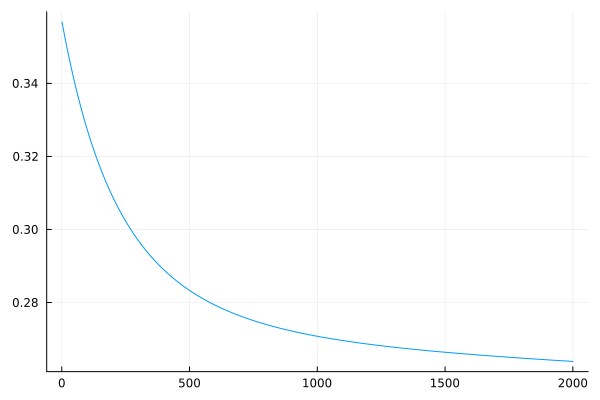

In [60]:
plot(1:num_epochs, losses, legend=false)

## 3. Evaluate our model

In this section, you will evaluate your model on train set and test set and make some comment about the result.

### Evaluate model on training set

In [61]:
preds_train = predict(W, add_one_train_x)

train_y_new = reshape(train_y_new, length(train_y_new), 1)
acc = accuracy(preds_train, train_y_new)
p = precision(preds_train, train_y_new)
r = recall(preds_train, train_y_new)
f1 = 2*p*r/(p + r)

print(" acc: $acc\n precision: $p\n recall: $r\n f1_score: $f1\n")

 acc: 0.9146666666666666
 precision: 0.9671658986175116
 recall: 0.24903589439335508
 f1_score: 0.3960839820712432


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\Admin\.julia\packages\MLJBase\VTQPI\src\measures\confusion_matrix.jl:116
┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\Admin\.julia\packages\MLJBase\VTQPI\src\measures\confusion_matrix.jl:116


### Evaluate model on test set

In order to predict the result on test set, you have to perform data pre-process first. The pre-process is done exactly what we have done on train set. That means, you have to:

- Change the label in `test_y` to `0` and `1` and store in a new variable named `test_y_new`
- Calculate `test_intensity` and `test_symmetry` to form `test_x_new` (the shape should be `(10000,2)`)
- Normalized `test_x_new` by z-score. Note the you will re-use variable `mean_` and `std_` to calculate `test_x_new` instead of compute new ones. You will store the result in `normalized_test_x`
- Add a column that's full of one to `test_x_new` and store in `add_one_test_x` (the shape should be `(10000,3)`)

In [62]:
#TODO

# compute test_y_new
test_y_new =  reshape(deepcopy(test_y), (size(test_y)[1], 1))
test_y_new[test_y_new .!= 1] .= 0
# compute test_intensity and test_symmetry to form test_x_new
test_intensity = (sum(test_x_flatten,dims=2) + sum(test_y,dims=2)) ./ 784
test_symmetry = compute_symmetry(test_x_flatten)
test_x_new = hcat(test_intensity,test_symmetry)
# normalize test_x_new
normalized_test_x = normalize(test_x_new, mean_, std_)
# add ones to normalized_test_x
add_one_test_x = hcat(ones(size(normalized_test_x)[1],), normalized_test_x)

size(add_one_test_x)


(10000, 3)

After doing all these stuffs, you now can predict and evaluate your model

In [63]:
preds_test = predict(W, add_one_test_x)

test_y_new = reshape(test_y_new, length(test_y_new), 1)
acc = accuracy(preds_test, test_y_new)
p = precision(preds_test, test_y_new)
r = recall(preds_test, test_y_new)
f1 = 2*p*r/(p + r)

print(" acc: $acc\n precision: $p\n recall: $r\n f1_score: $f1\n")

 acc: 0.914
 precision: 0.9365079365079365
 recall: 0.2599118942731278
 f1_score: 0.40689655172413797


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\Admin\.julia\packages\MLJBase\VTQPI\src\measures\confusion_matrix.jl:116
┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\Admin\.julia\packages\MLJBase\VTQPI\src\measures\confusion_matrix.jl:116


**TODO: Comment on the result**
- Accuracy, Precision are high (>90%) but Recall low. Recall drags F1_score low too.